In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

renewables_csv = 'renewable-share-energy.csv'
co2_csv = 'consumption-co2-per-capita.csv'
gdp_file = "world_bank_GDP_per_country.csv"
country_code_names_csv = 'country_code_names.csv'

# Global code

In [3]:
country_code_names = pd.read_csv(country_code_names_csv, index_col=0)

In [4]:
country_name = "Country Name"

In [5]:
display(country_code_names.loc['ZAF', country_name])

'South Africa'

# functions to turn the CSV files into Pandas dataframes

In [6]:
# functions to turn the CSV files into Pandas dataframes

def vertical_to_horizontal(csv_file):
    # Read the CSV file into a DataFrame
    dataframe = pd.read_csv(csv_file)

    # Pivot the DataFrame based on 'Entity' column
    pivoted_df = dataframe.pivot_table(index='Year', columns='Code', values=dataframe.columns[3]).reset_index()
    
    return pivoted_df

# flipping the data and removing unused years.

renewables_flipped = vertical_to_horizontal(renewables_csv)
renewables_flipped = renewables_flipped[(renewables_flipped['Year'] >= 1990) & (renewables_flipped['Year'] <= 2020)]

co2_flipped = vertical_to_horizontal(co2_csv)
co2_flipped = co2_flipped[(co2_flipped['Year'] >= 1990) & (co2_flipped['Year'] <= 2020)]

non_country_entities = [
    'High-income countries', 'South America', 'Europe', 'Oceania', 'Africa',
    'Lower-middle-income countries', 'Upper-middle-income countries', 'World',
    'North America', 'European Union (27)', 'Asia', 'OWID_WRL'
]

def filter_countries_1990_2020(df):
    # Filter the DataFrame to keep only rows for 1990 and 2020
    df_1990 = df[df['Year'] == 1990]
    df_2020 = df[df['Year'] == 2020]

    # Extract the countries that have data in both 1990 and 2020
    countries_1990 = set(df_1990.columns[df_1990.notnull().any()])
    countries_2020 = set(df_2020.columns[df_2020.notnull().any()])

    countries_both_years = list(countries_1990.intersection(countries_2020))

    # Filter the original DataFrame to include only columns (countries) present in both 1990 and 2020
    filtered_df = df[df.columns[df.columns.isin(countries_both_years)]]

    return filtered_df

renewables_flipped = filter_countries_1990_2020(renewables_flipped)
co2_flipped = filter_countries_1990_2020(co2_flipped)

def filter_common_countries(df1, df2):
    countries_df1 = set(df1.columns)
    countries_df2 = set(df2.columns)
    common_countries = list(countries_df1.intersection(countries_df2))

    # Exclude 'Year' from removal if present in common columns
    if 'Year' in common_countries:
        common_countries.remove('Year')

    # Filter DataFrames to include only common countries (excluding 'Year')
    filtered_df1 = df1[['Year'] + common_countries]
    filtered_df2 = df2[['Year'] + common_countries]

    return filtered_df1, filtered_df2

renewables_filtered, co2_filtered = filter_common_countries(renewables_flipped, co2_flipped)

# Remove non-country entities from the DataFrames
renewables_filtered = renewables_filtered.drop(columns=non_country_entities, errors='ignore')
renewables_filtered.set_index('Year', inplace=True)
renewables_filtered.interpolate(method='linear')

co2_filtered = co2_filtered.drop(columns=non_country_entities, errors='ignore')
co2_filtered.set_index('Year', inplace=True)
co2_filtered = co2_filtered.interpolate(method='linear')

display(renewables_filtered.head(3))
display(co2_filtered.head(3))


Code        TUR        VEN        BRA       BGD       IRL        CAN  \
Year                                                                   
1990  12.219702  18.119040  44.531140  3.539271  1.748312  29.480997   
1991  11.752680  21.675652  45.268887  3.477609  1.801310  30.499428   
1992  13.079588  21.255587  45.736390  3.028885  1.975835  30.512110   

Code       LTU       MEX       PER       DEU  ...       ESP       THA  \
Year                                          ...                       
1990  0.606307  6.590639  29.33260  1.336941  ...  7.198869  4.114763   
1991  0.468239  6.157738  32.41311  1.270958  ...  7.452908  3.434534   
1992  0.703257  7.048654  28.13108  1.520455  ...  5.013249  2.892745   

Code       POL       EGY       KOR       JPN        LVA       IND        AUT  \
Year                                                                           
1990  0.360697  7.520866  1.299518  5.605646  15.375505  8.542830  28.908712   
1991  0.378213  7.396339  0.855261  5.917130  12.153858  9.029866  27.587229   
1992  0.424809  7.380687  0.674040  5.080176  13.070239  8.140624  31.037298   

Code       RUS  
Year            
1990  4.898305  
1991  5.003191  
1992  5.336780  

[3 rows x 60 columns]

Code       TUR       VEN       BRA       BGD        IRL        CAN        LTU  \
Year                                                                            
1990  3.970047  4.762998  1.629641  0.170461  11.350045  17.463978  11.455255   
1991  3.868271  4.826739  1.644316  0.177141  11.799738  17.216078  12.141571   
1992  4.437934  4.589158  1.630011  0.185828  12.238233  17.475994  13.901977   

Code       MEX       PER        DEU  ...       ESP       THA       POL  \
Year                                 ...                                 
1990  3.927316  1.078684  15.016723  ...  6.823517  2.151179  8.468872   
1991  4.058703  1.046741  14.304148  ...  6.953576  2.151470  8.829851   
1992  4.070049  1.043356  15.013348  ...  7.483764  2.716419  9.084440   

Code       EGY       KOR        JPN       LVA       IND        AUT        RUS  
Year                                                                           
1990  1.431379  7.257062  10.653232  8.031676  0.660851  11.629516  13.794909  
1991  1.336157  7.683075  10.770959  7.425428  0.671166  11.735809  13.999880  
1992  1.456119  8.837342  11.439899  6.927283  0.712204  11.870350   5.236676  

[3 rows x 60 columns]

In [7]:
def gdp_dataframe(directory):
    dataframe = pd.read_csv(directory)
    dataframe.set_index('Year', inplace=True)

    transposed_df = dataframe.transpose()
    
    return transposed_df

In [8]:
gdp_filtered = gdp_dataframe(gdp_file)

# Renewables GDP per capita functions

In [9]:
# Renewables GDP per capita function

common_columns = co2_filtered.columns.intersection(gdp_filtered.columns)

# Creating the DataFrame with NaN values
df_ratio_CO2percapita_perGDP = pd.DataFrame(index=co2_filtered.index, columns=common_columns)

# Performing the division for common columns while handling missing values
for col in common_columns:
    df_ratio_CO2percapita_perGDP[col] = co2_filtered[col].combine_first(gdp_filtered[col]) / gdp_filtered[col]

display(df_ratio_CO2percapita_perGDP)

TUR  VEN  BRA  BGD  IRL  CAN  LTU  MEX  PER  DEU  ...  ESP  THA  POL  \
Year                                                    ...                  
1990  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1991  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1992  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1993  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1994  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1995  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1996  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1998  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1999  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2001  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2002  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2003  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2004  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2005  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2006  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2007  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2008  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2009  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2010  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2011  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2012  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2013  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2014  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2015  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2016  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2017  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2018  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2019  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2020  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      EGY  KOR  JPN  LVA  IND  AUT  RUS  
Year                                     
1990  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1991  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1992  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1993  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1994  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1995  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1996  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1998  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1999  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2001  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2002  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2003  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2004  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2005  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2006  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2007  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2008  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2009  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2010  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2011  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2012  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2013  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2014  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2015  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2016  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2017  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2018  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[31 rows x 59 columns]

# Plotting individual country Renewables and Per capita consumption-based CO2 emissions over time

In [10]:
def plot_dataframes(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)

    for column in columns:
        fig, ax1 = plt.subplots(figsize=(8, 5))

        ax1.plot(df1.index, df1[column], marker='o', color='tab:blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel(f'Renewables (% equivalent primary energy)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(df2.index, df2[column], marker='o', color='tab:green')
        ax2.set_ylabel(f'Per capita consumption-based CO2 emissions', color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        plt.title(f'Renewables and Per capita consumption-based CO2 emissions over time ({country_code_names.loc[column, country_name]})')
        plt.show()

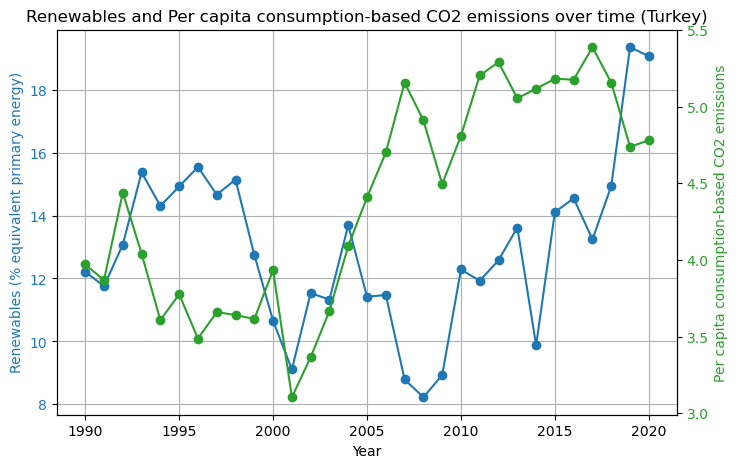

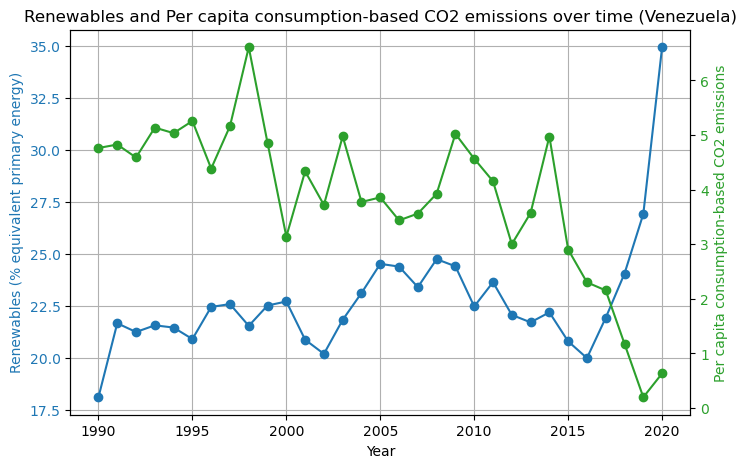

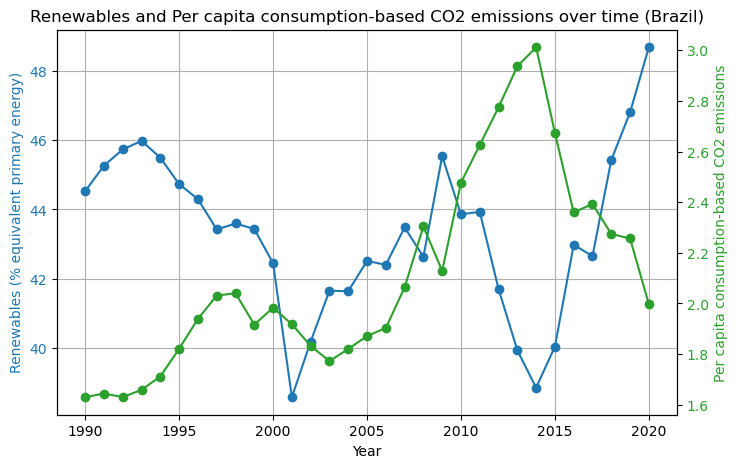

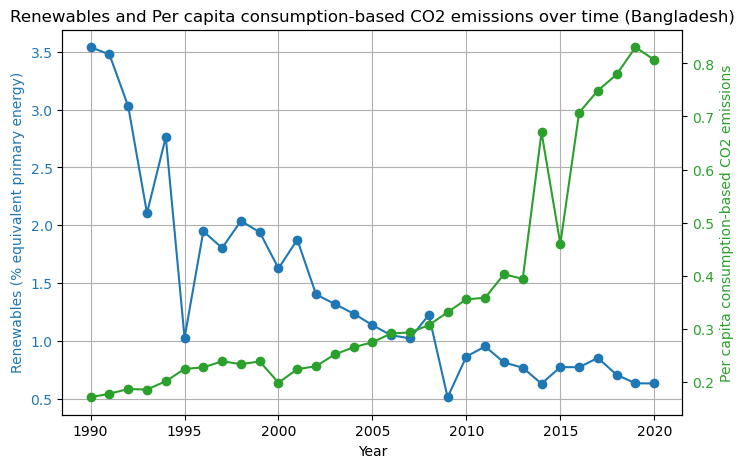

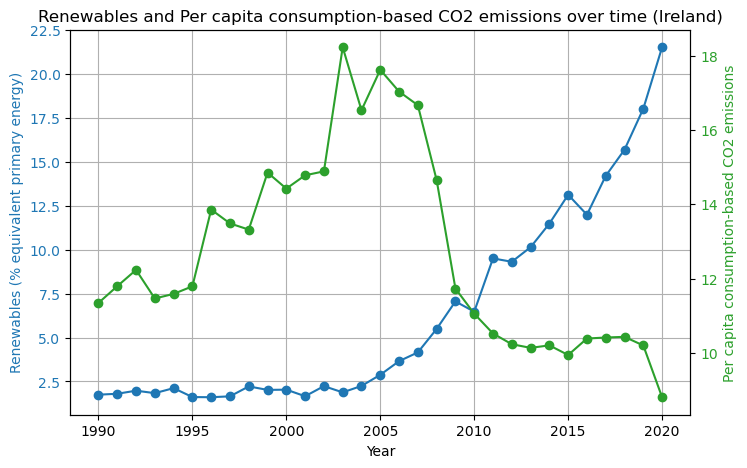

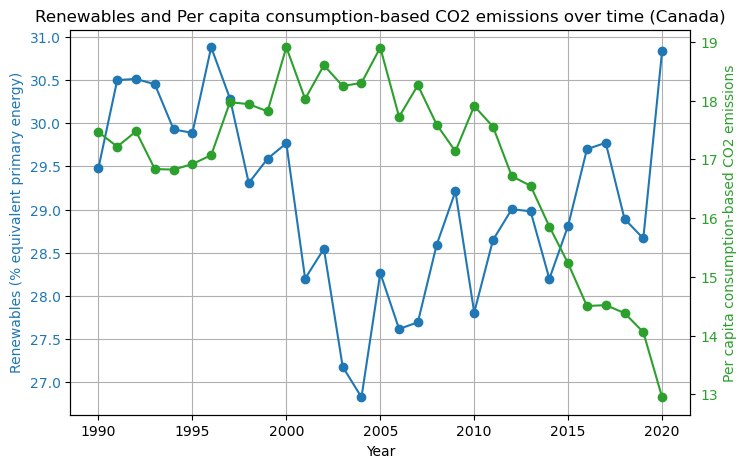

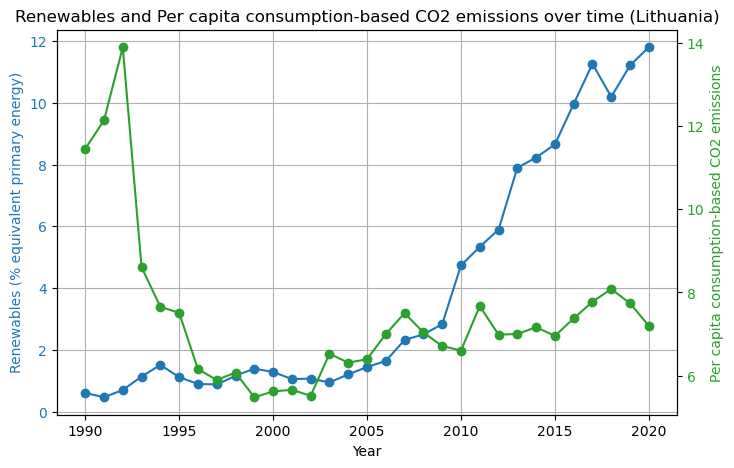

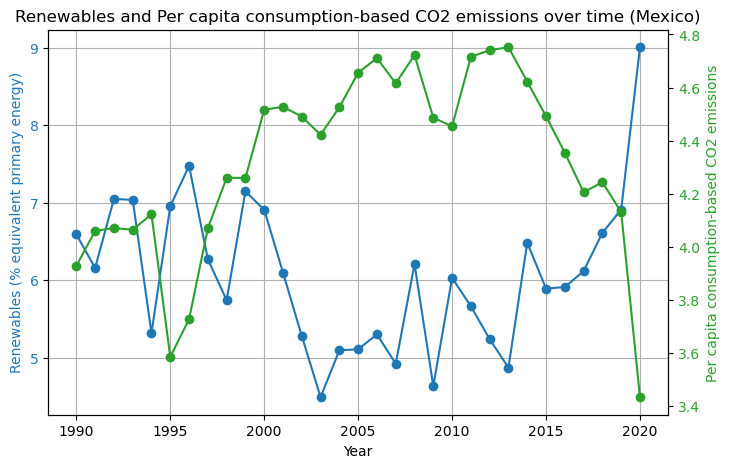

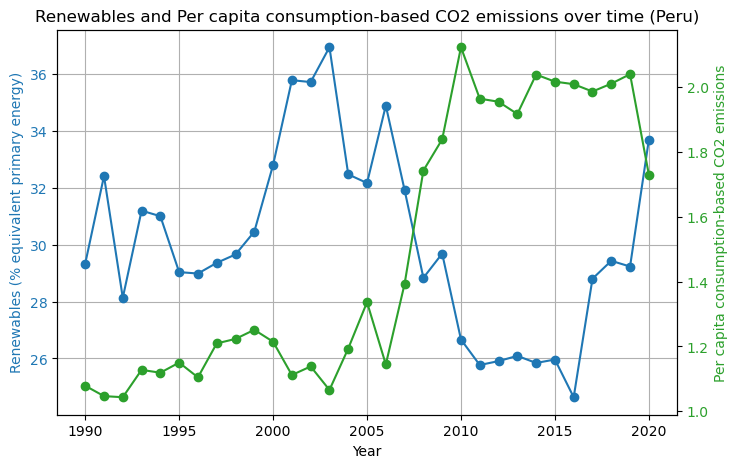

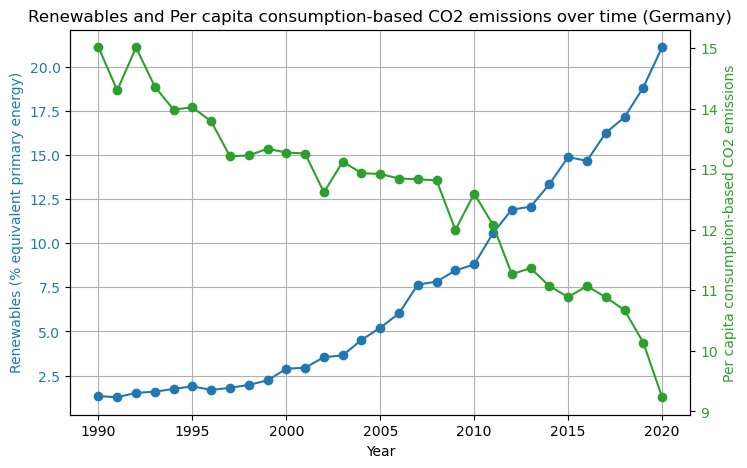

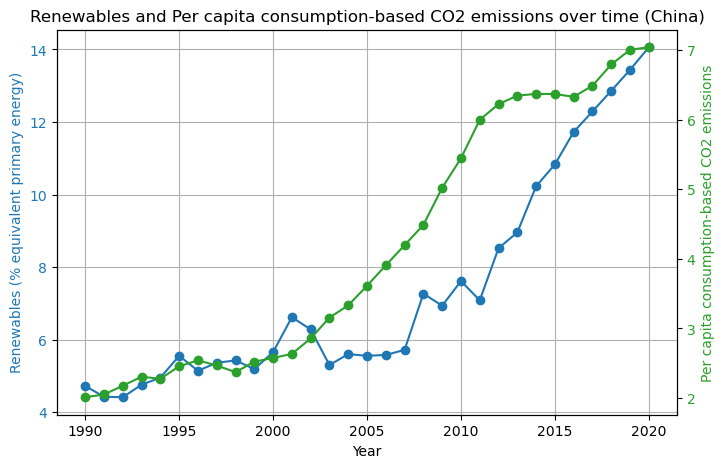

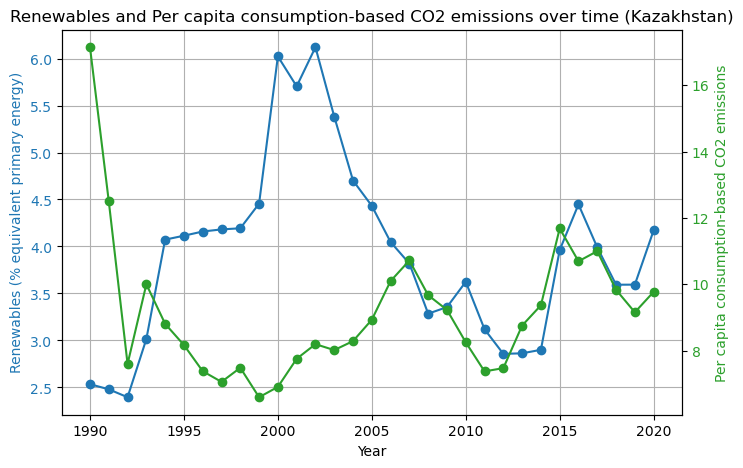

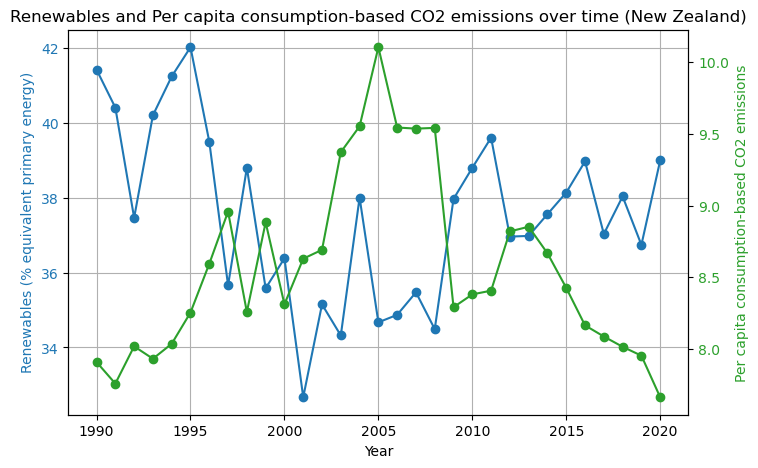

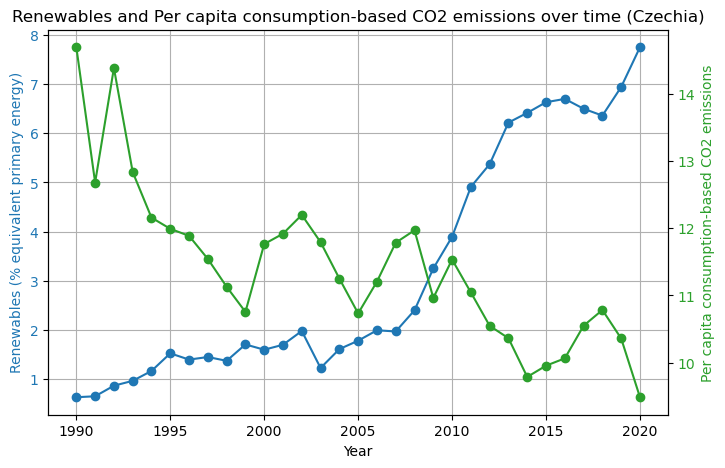

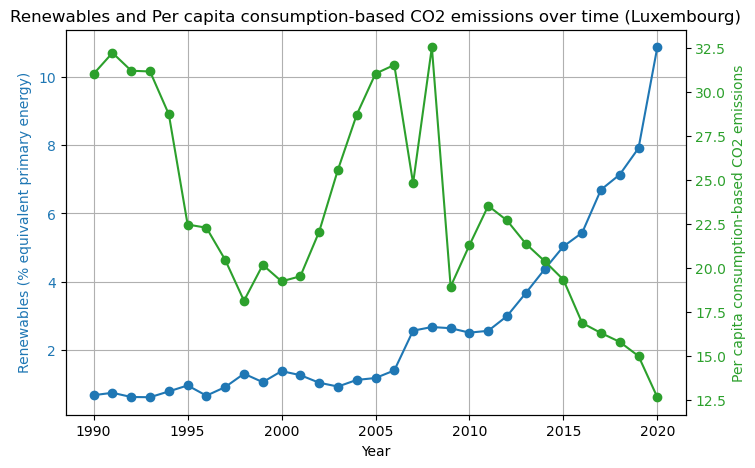

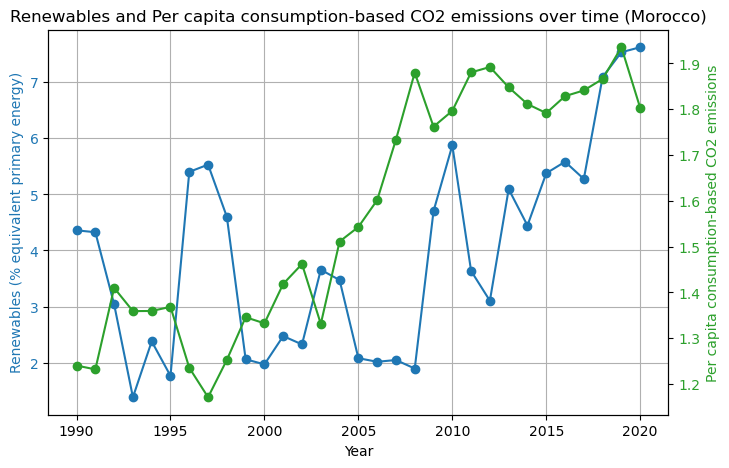

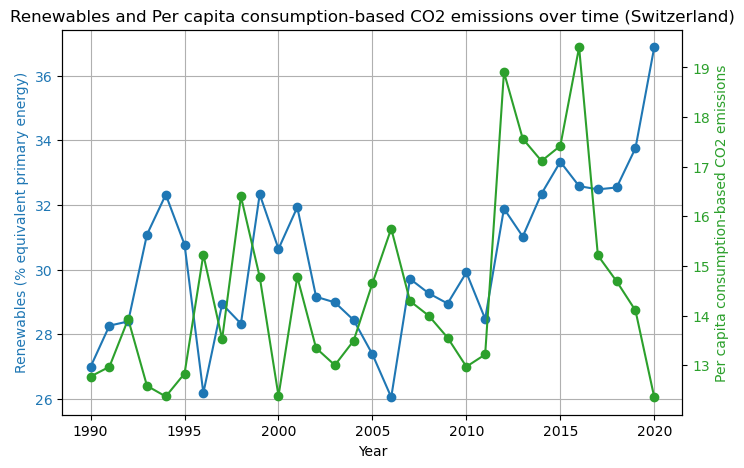

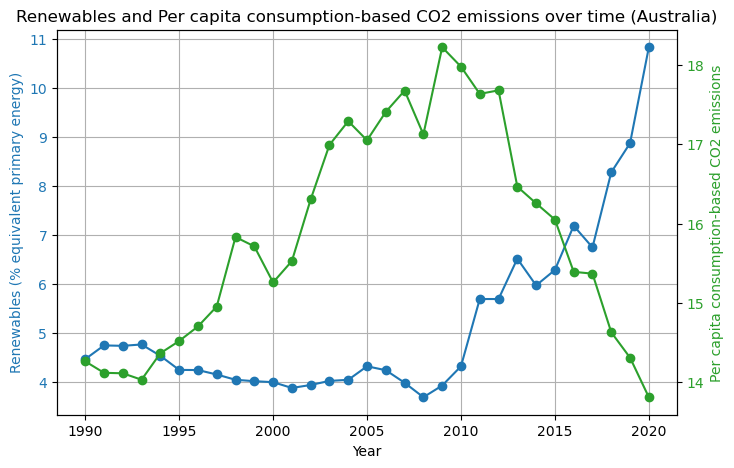

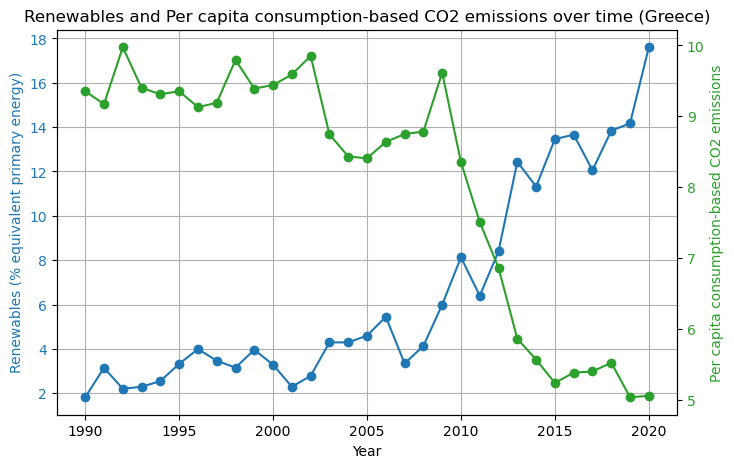

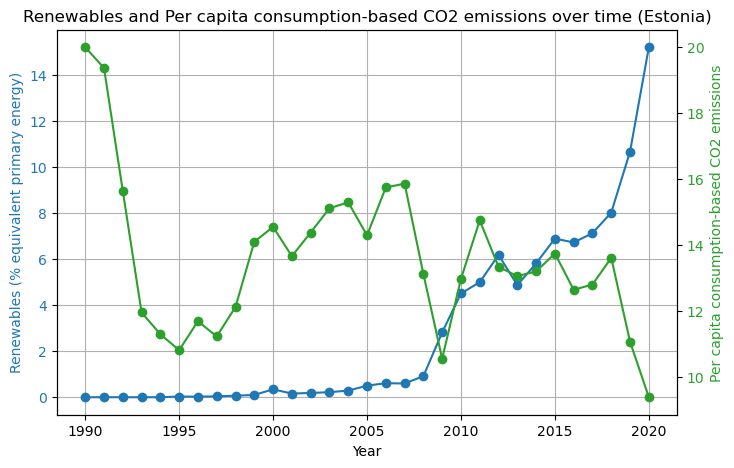

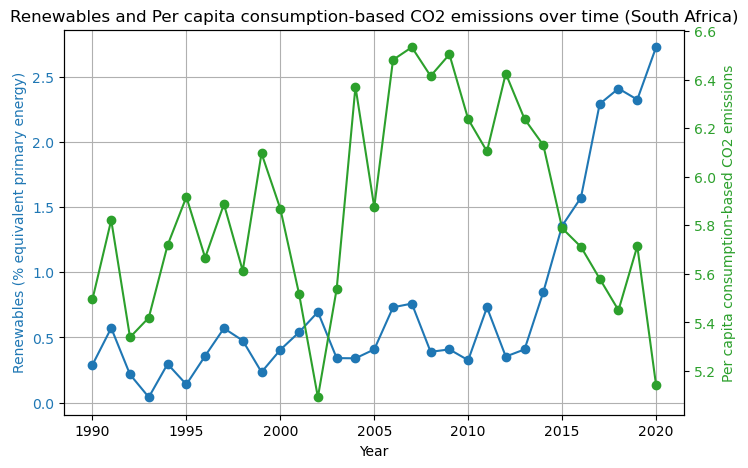

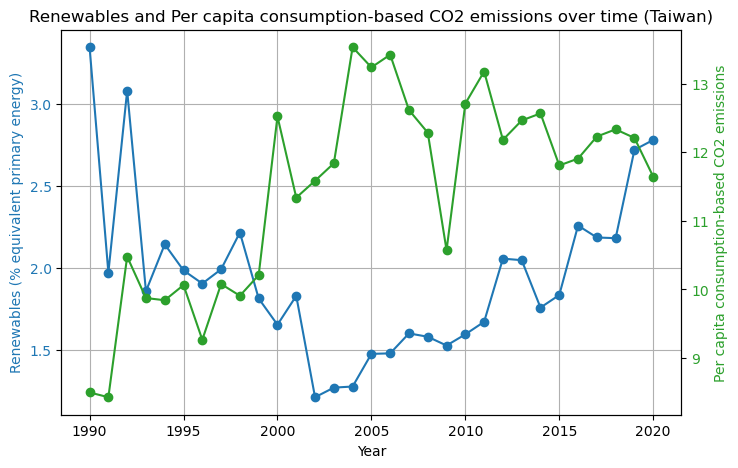

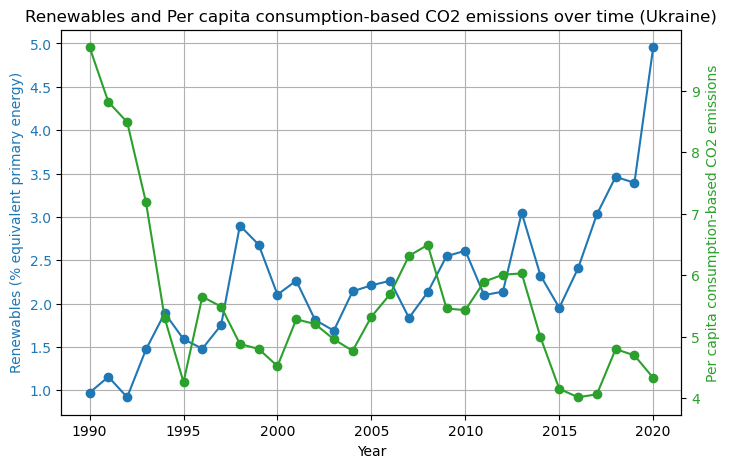

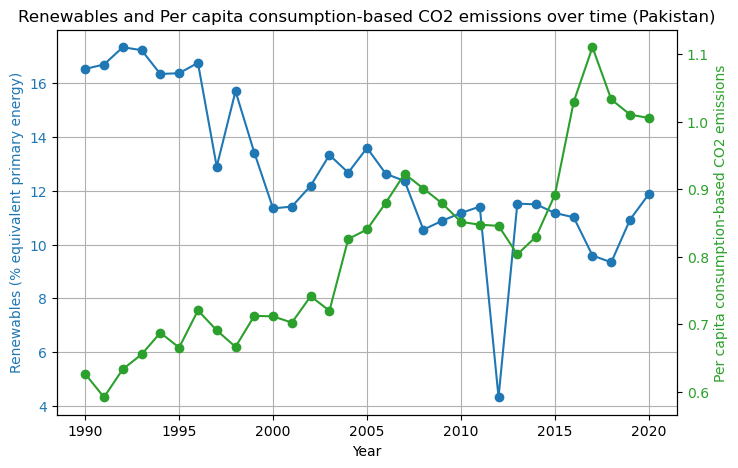

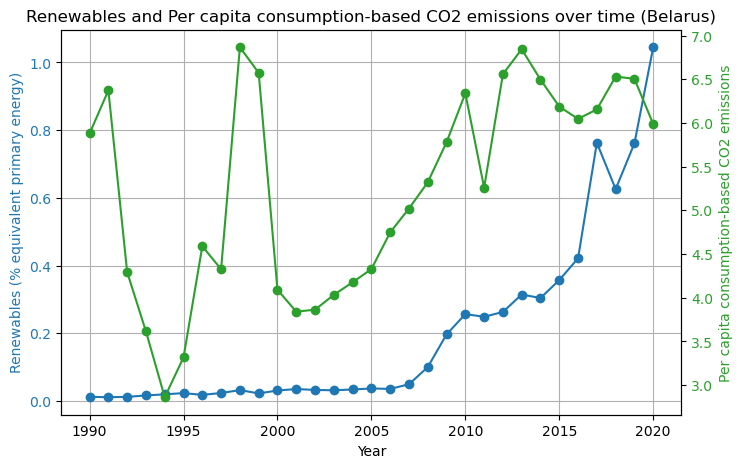

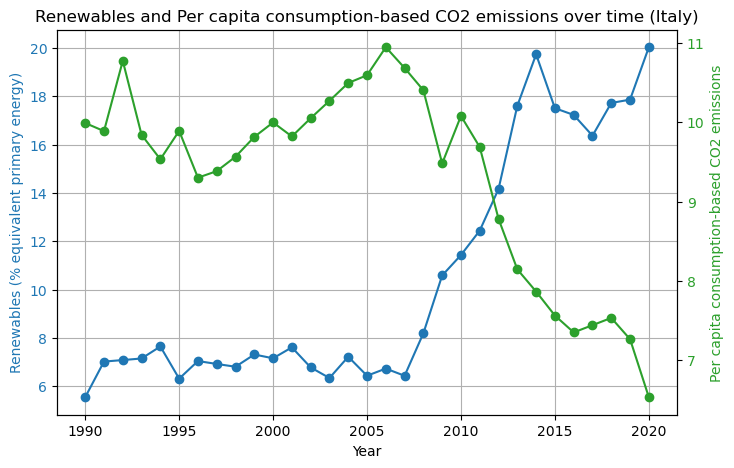

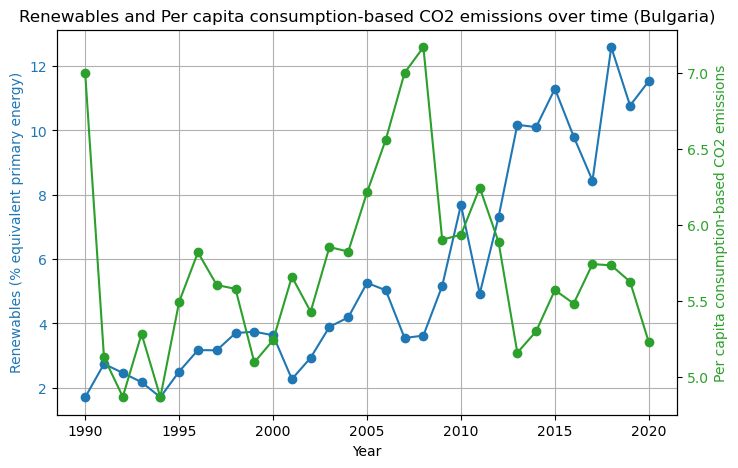

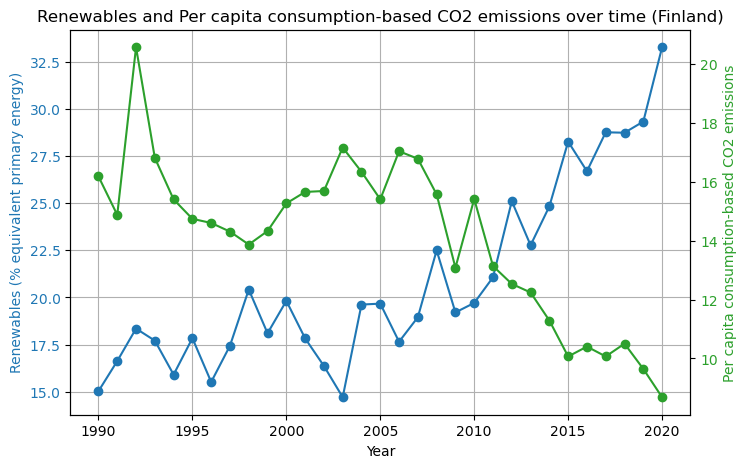

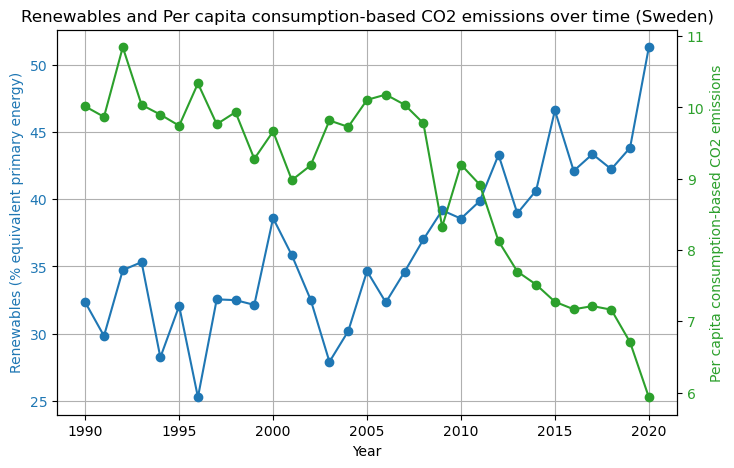

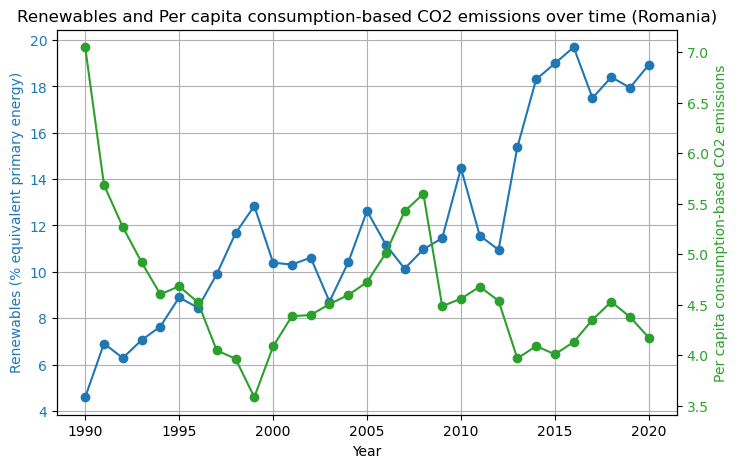

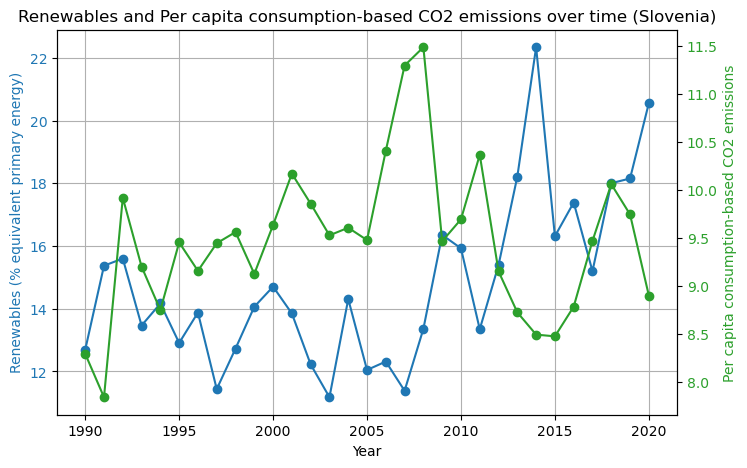

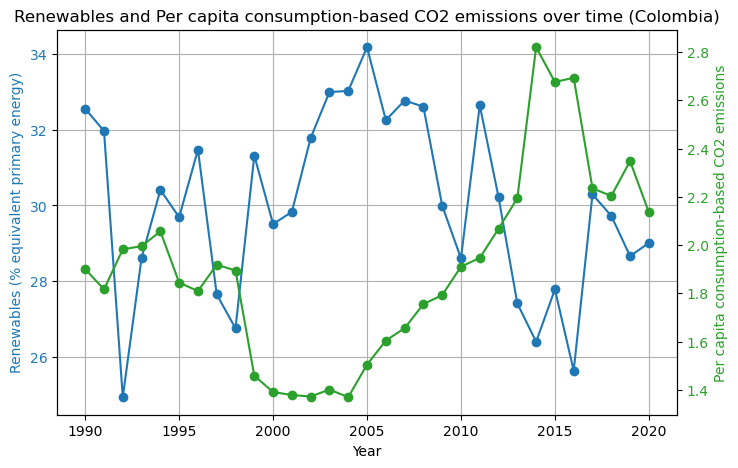

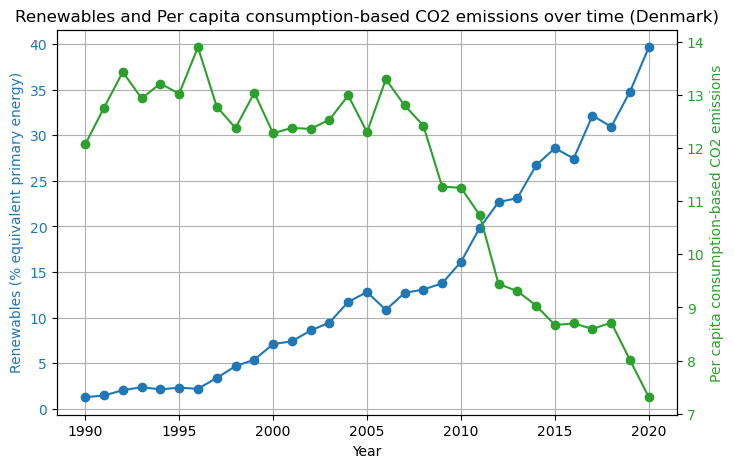

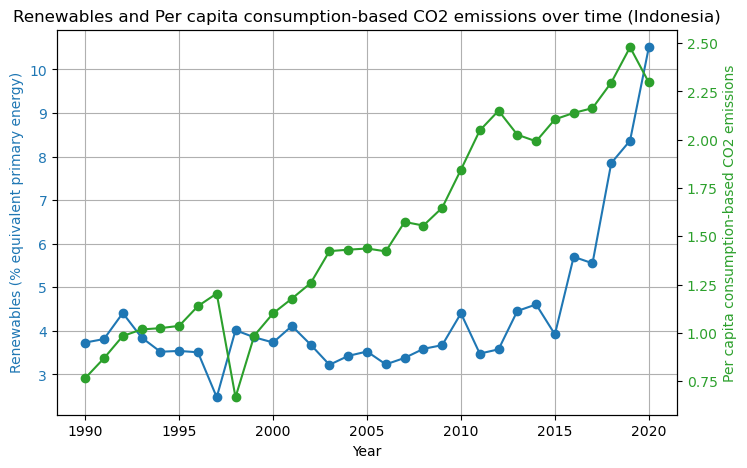

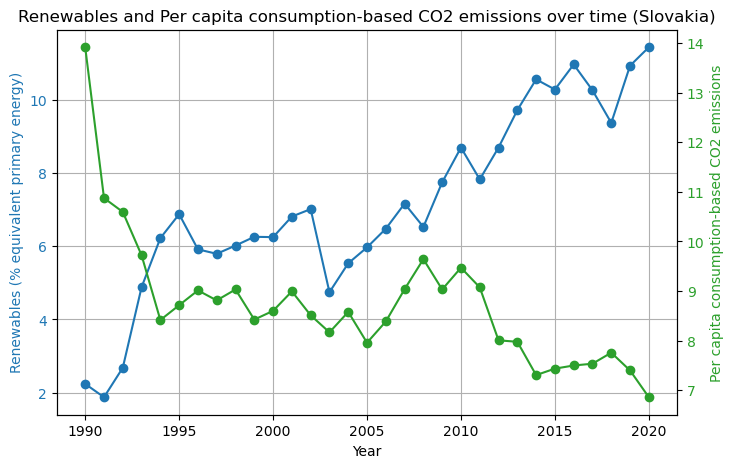

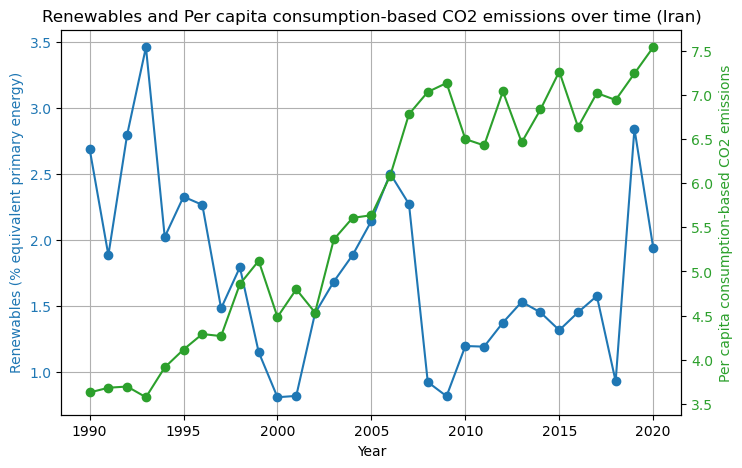

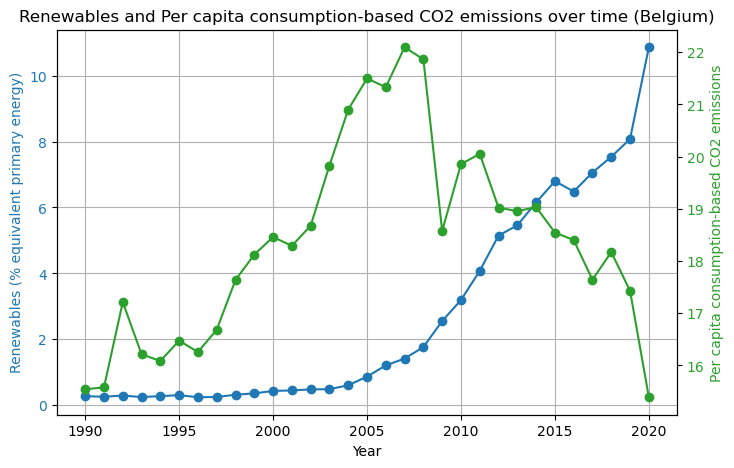

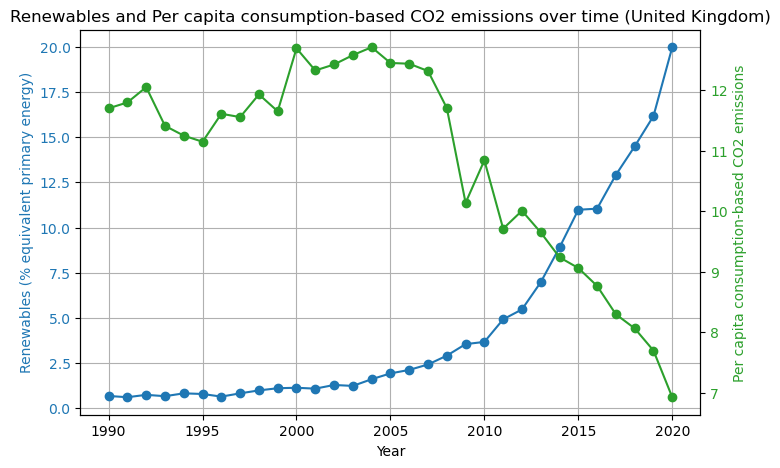

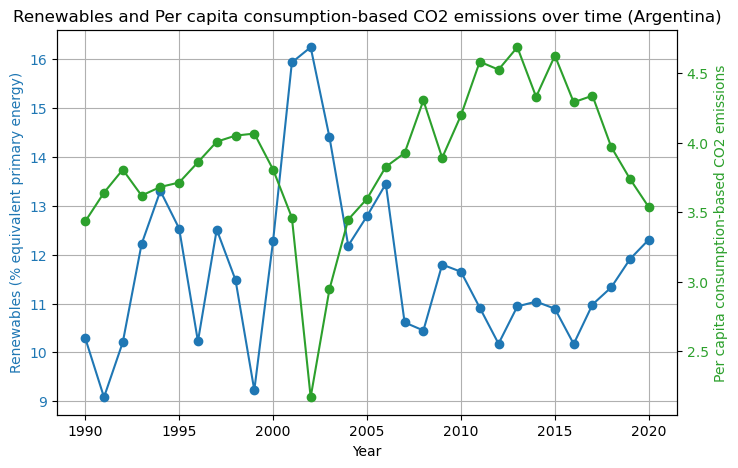

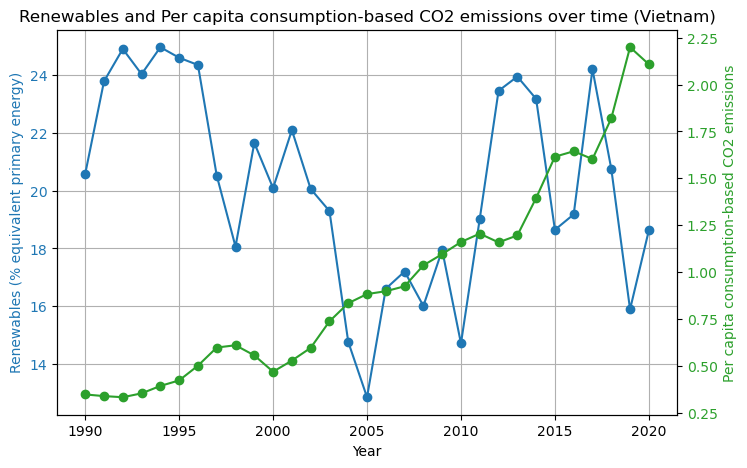

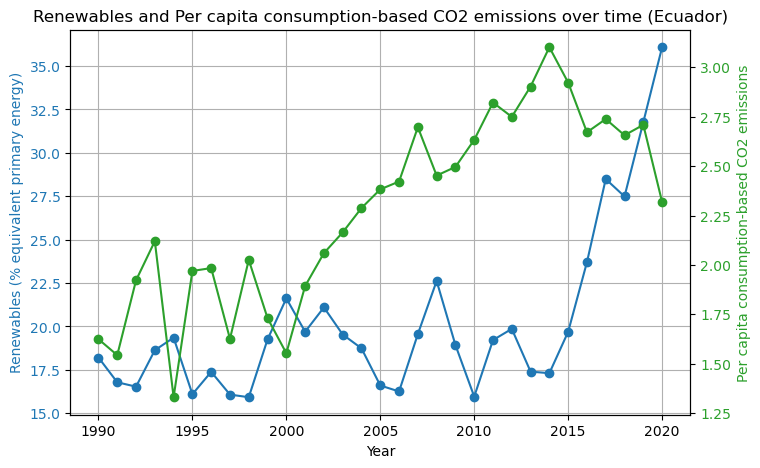

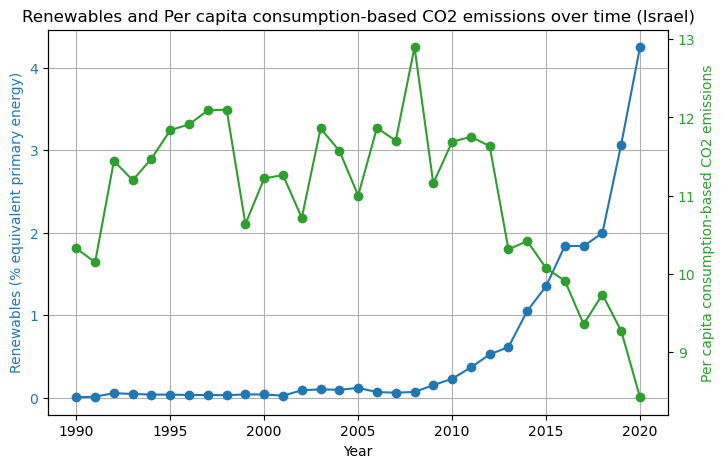

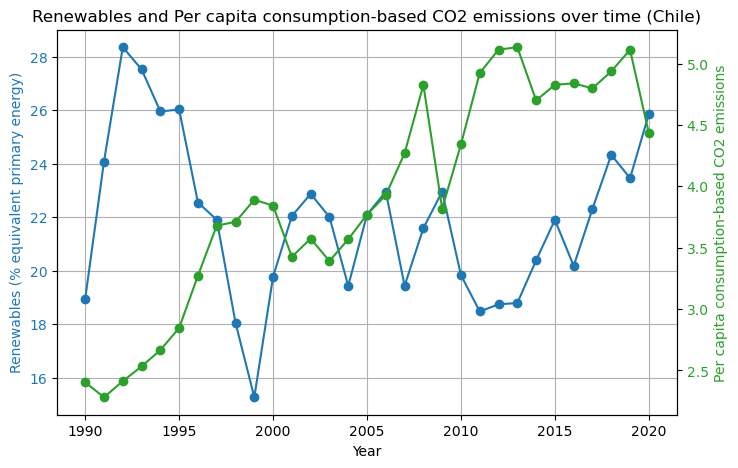

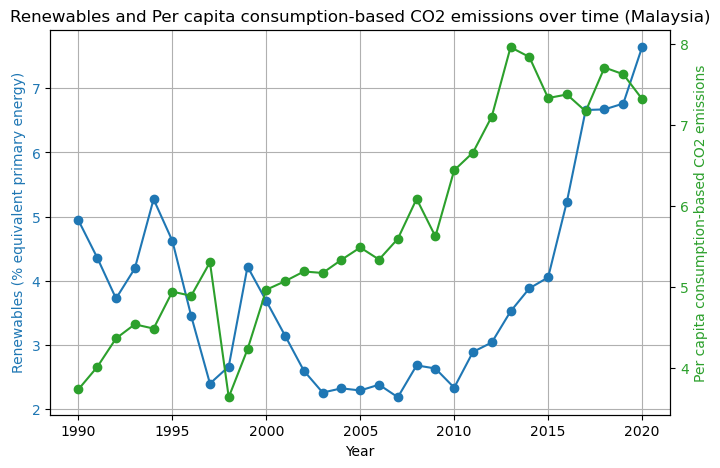

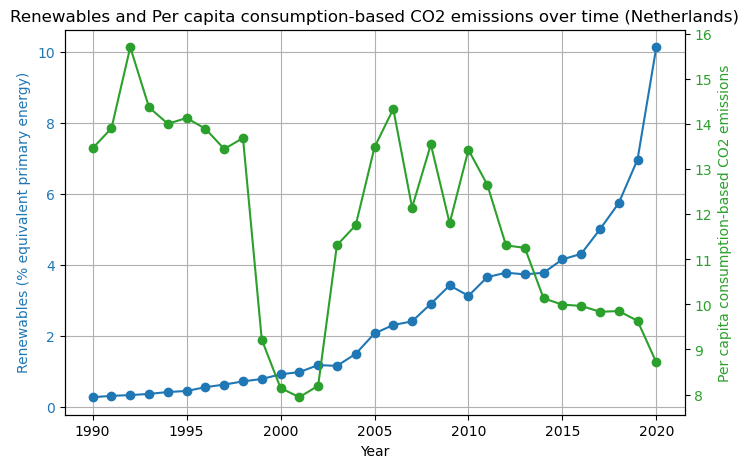

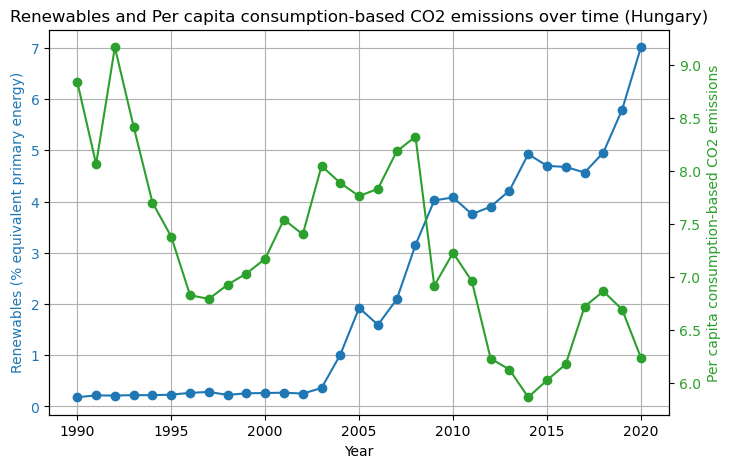

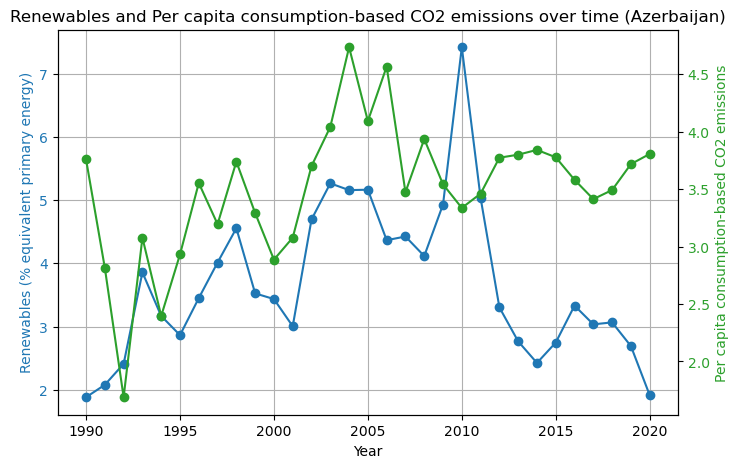

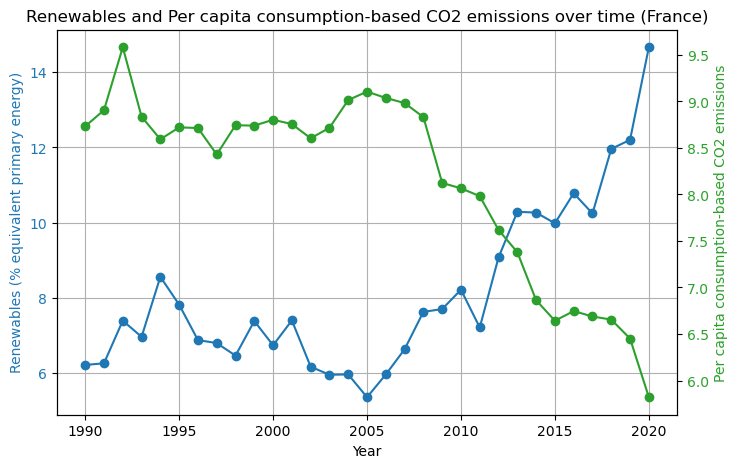

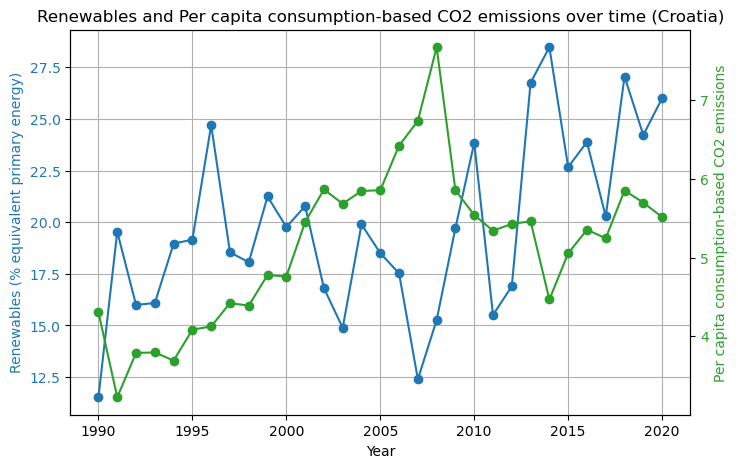

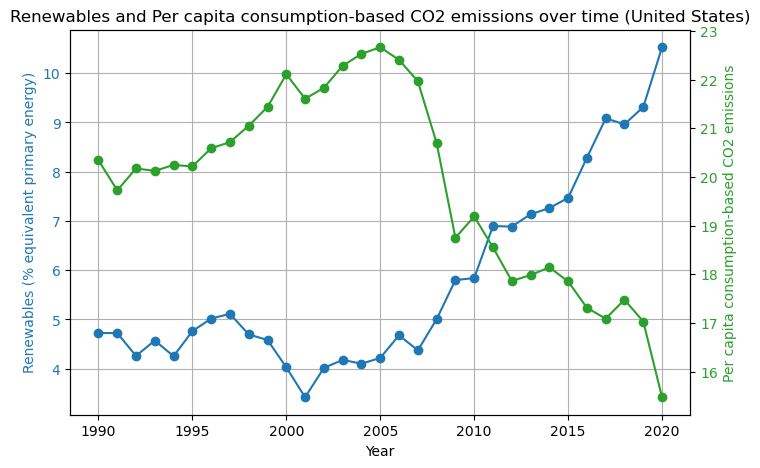

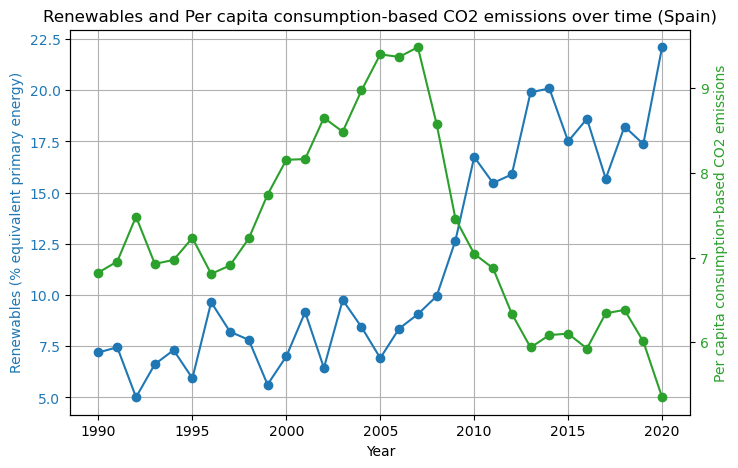

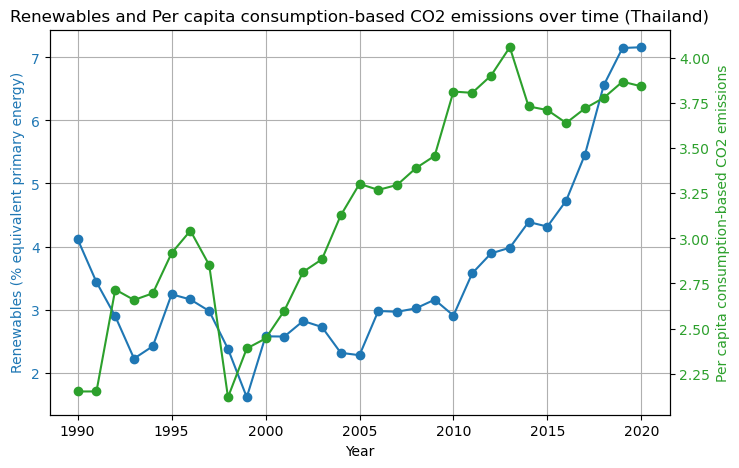

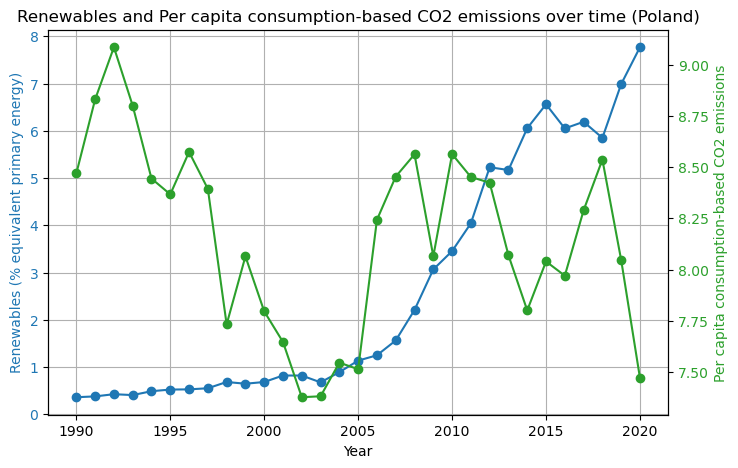

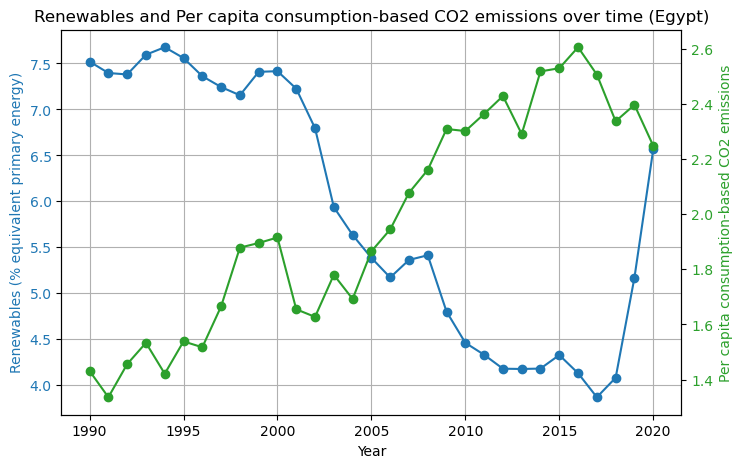

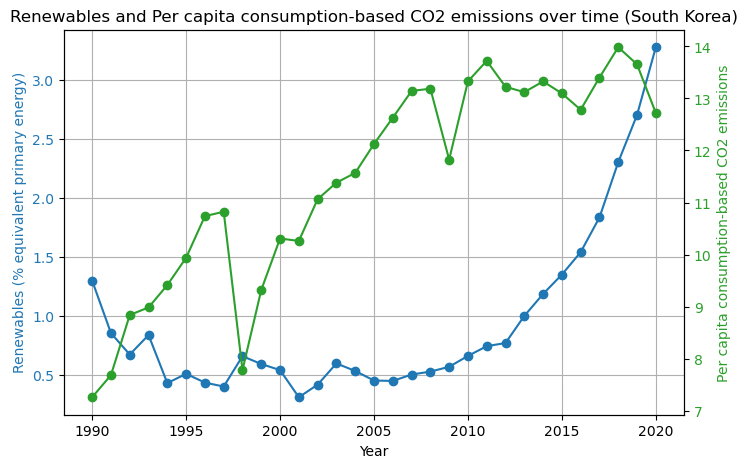

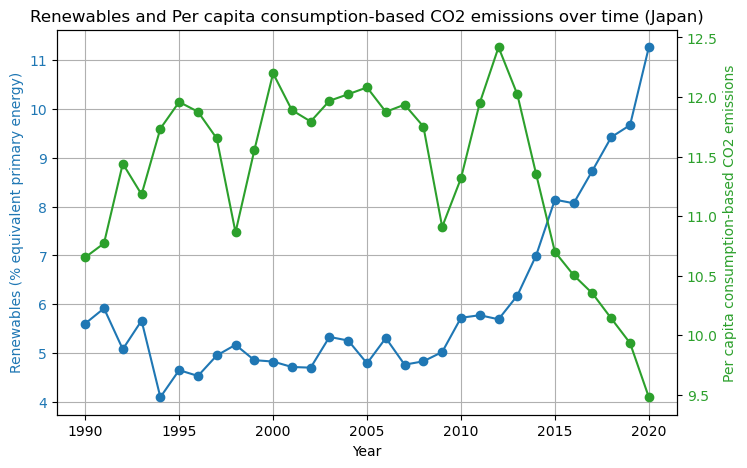

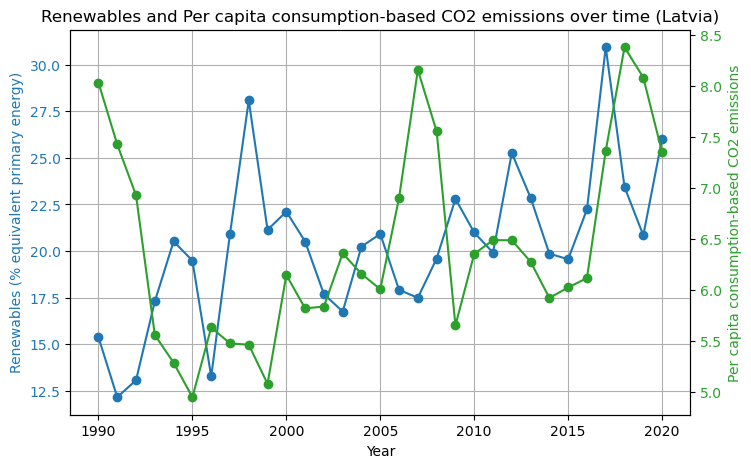

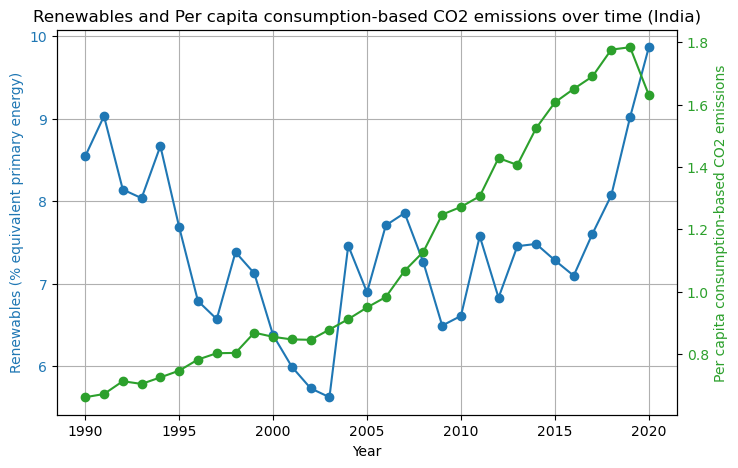

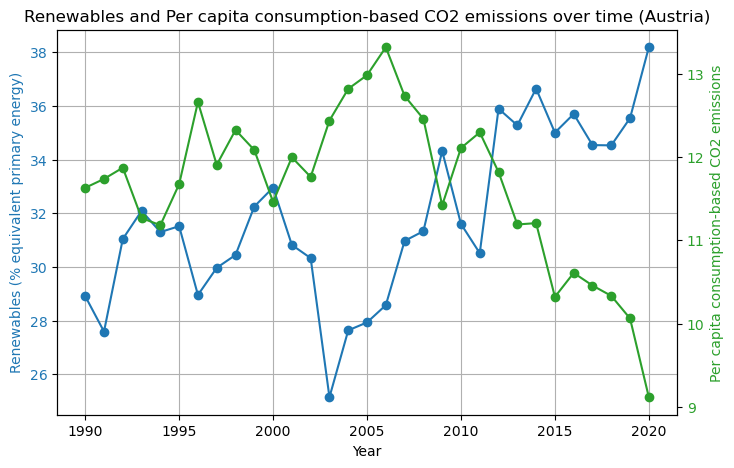

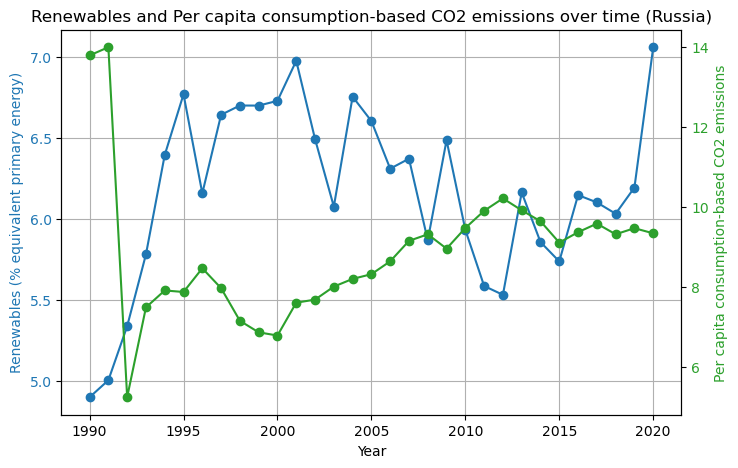

In [11]:
plot_dataframes(renewables_filtered, co2_filtered)

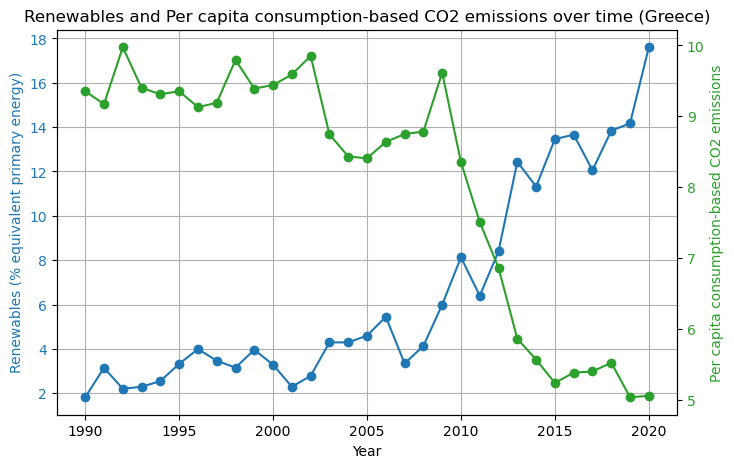

In [12]:
# How to plot one country
plot_dataframes(pd.DataFrame(renewables_filtered['GRC']), pd.DataFrame(co2_filtered['GRC']))

# Calculating Pearson correlation coefficients

In [13]:
def calculate_correlation(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)
    correlations = {'Country Code': [], 'Correlation': [], 'P-Value': []}

    for column in columns:
        correlation, p_value = pearsonr(df1[column], df2[column])
        correlations['Country Code'].append(column)
        correlations['Correlation'].append(correlation)
        correlations['P-Value'].append(p_value)

    correlation_df = pd.DataFrame(correlations)
    return correlation_df

In [26]:
def plot_correlation_bars(correlation_df, plot_title):
    correlation_df_sorted = correlation_df.sort_values(by='Correlation')

    # Splitting into positive and negative values
    positive_corr = correlation_df_sorted[correlation_df_sorted['Correlation'] >= 0]
    negative_corr = correlation_df_sorted[correlation_df_sorted['Correlation'] < 0]

    plt.figure(figsize=(13, 7))

    # Plotting negative values with custom color (red)
    plt.bar(negative_corr['Country Code'], negative_corr['Correlation'], color='tab:red')
    # Plotting positive values with custom color (blue)
    plt.bar(positive_corr['Country Code'], positive_corr['Correlation'], color='tab:blue')

    # Annotating country code labels on top of the bars at y=0
    for index, row in correlation_df_sorted.iterrows():
        plt.text(row['Country Code'], 0, country_code_names.loc[row["Country Code"], country_name], ha='center', va='bottom', rotation=90)

    plt.title(plot_title)
    plt.xlabel('Country Code')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='center')  # Centering the tick labels
    plt.legend(['Negative Correlation', 'Positive Correlation'], loc='upper right')

    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

# Calculating Spearmans correlations

In [30]:
def calculate_spearmans_correlation(df1, df2):
    # Assuming the columns in df1 and df2 are aligned (same columns in both DataFrames)
    columns = df1.columns.intersection(df2.columns)
    correlations = {'Country Code': [], 'Correlation': [], 'P-Value': []}

    for column in columns:
        correlation, p_value = spearmanr(df1[column], df2[column])
        correlations['Country Code'].append(column)
        correlations['Correlation'].append(correlation)
        correlations['P-Value'].append(p_value)

    correlation_df = pd.DataFrame(correlations)
    return correlation_df

# LRM tests

In [73]:
def lrm_test(df1, df2):
    
    columns = df1.columns.intersection(df2.columns)
    results = {'Country Code': [], 'Intercept': [], 'Slope': []}

    for column in columns:
        x = df1[column]
        y = df2[column]
        
        x = sm.add_constant(x)
        # Fit the linear regression model
        model = sm.OLS(y, x).fit()

        #results
        intercept = model.params[0]
        slope = model.params[1]

        results['Country Code'].append(column)
        results['Intercept'].append(intercept)
        results['Slope'].append(slope)
    
    results_df = pd.DataFrame(results)
    return results_df

In [72]:
def plot_slopes(results_df):
    df_sorted = results_df.sort_values(by='Slope')
    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['Country Code'], df_sorted['Slope'], color='skyblue')

    for index, row in df_sorted.iterrows():
        plt.text(row['Country Code'], 0, country_code_names.loc[row["Country Code"], country_name], ha='center', va='bottom', rotation=90)

    plt.xlabel('Column')
    plt.ylabel('Slope')
    plt.title('Slopes of Linear Regressions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Granger causality test

In [108]:
def grangers_causation_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def grangertest(df1, df2, maxlag, test='ssr_chi2test'):
    columns = df1.columns.intersection(df2.columns)

    for column in columns:
        combined_dataframe = pd.concat([df1[[column]], df2[[column]]], axis=1)
        variables = [column, column]
        grangers_causation_matrix(combined_dataframe, variables, maxlag=maxlag, test=test, verbose=False)

In [109]:
grangertest(renewables_filtered, co2_filtered, 4)

c:\Users\Leonards\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ValueError: wrong shape for coefs

In [103]:
def granger_causality_test(df1, df2, max_lag):
    columns = df1.columns.intersection(df2.columns)

    results = {}
    for column in columns:
        combined_dataframe = pd.concat([df1[[column]], df2[[column]]], axis=1)

        first_column = combined_dataframe.iloc[:,0]
        second_column = combined_dataframe.iloc[:,1]

        test_result = grangercausalitytests(combined_dataframe, max_lag)
        results[column] = [test_result[i + 1][0]['ssr_ftest'][0] for i in range(count(columns))]

        print(test_result)

    results_df = pd.DataFrame(results, index=[f'Lag_{i+1}' for i in range(max_lag)])
    return results_df

In [110]:
granger_causality_test(renewables_filtered, co2_filtered, 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4527  , p=0.5068  , df_denom=27, df_num=1
ssr based chi2 test:   chi2=0.5030  , p=0.4782  , df=1
likelihood ratio test: chi2=0.4989  , p=0.4800  , df=1
parameter F test:         F=0.4527  , p=0.5068  , df_denom=27, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9135  , p=0.4146  , df_denom=24, df_num=2
ssr based chi2 test:   chi2=2.2075  , p=0.3316  , df=2
likelihood ratio test: chi2=2.1276  , p=0.3451  , df=2
parameter F test:         F=0.9135  , p=0.4146  , df_denom=24, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1771  , p=0.3422  , df_denom=21, df_num=3
ssr based chi2 test:   chi2=4.7083  , p=0.1944  , df=3
likelihood ratio test: chi2=4.3518  , p=0.2259  , df=3
parameter F test:         F=1.1771  , p=0.3422  , df_denom=21, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3142  , p=0.0336  , df_d

NameError: name 'count' is not defined

# Running tests without detrending

In [75]:
def run_tests(renewables_filtered, co2_filtered):
    plot_dataframes(pd.DataFrame(renewables_filtered['GRC']), pd.DataFrame(co2_filtered['GRC']))

    # run Pearson correlation
    pearson_cor_coeficient_per_capita = calculate_correlation(renewables_filtered, co2_filtered)
    # plotting correlation bars by country
    plot_correlation_bars(pearson_cor_coeficient_per_capita, 'Pearson Correlation Coefficients (Sorted)')

    # run Spearman correlation and plot
    spearmans = calculate_spearmans_correlation(renewables_filtered, co2_filtered)
    plot_correlation_bars(spearmans, 'Spearman Correlation Coefficients (Sorted)')

    # run LRM tests
    lrm_results = lrm_test(renewables_filtered, co2_filtered)
    plot_slopes(lrm_results)

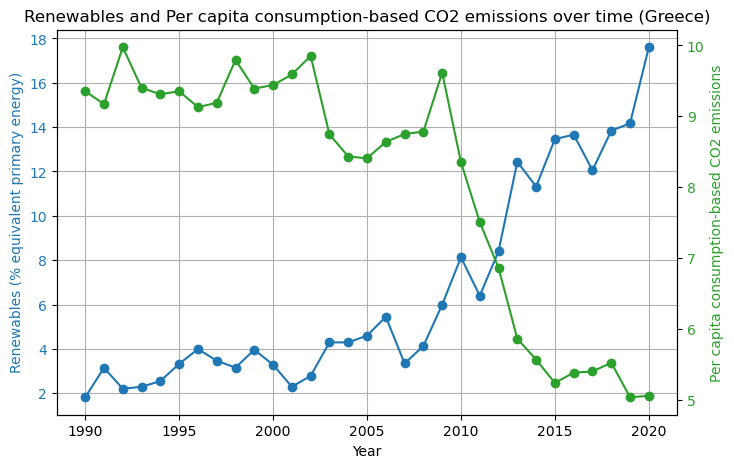

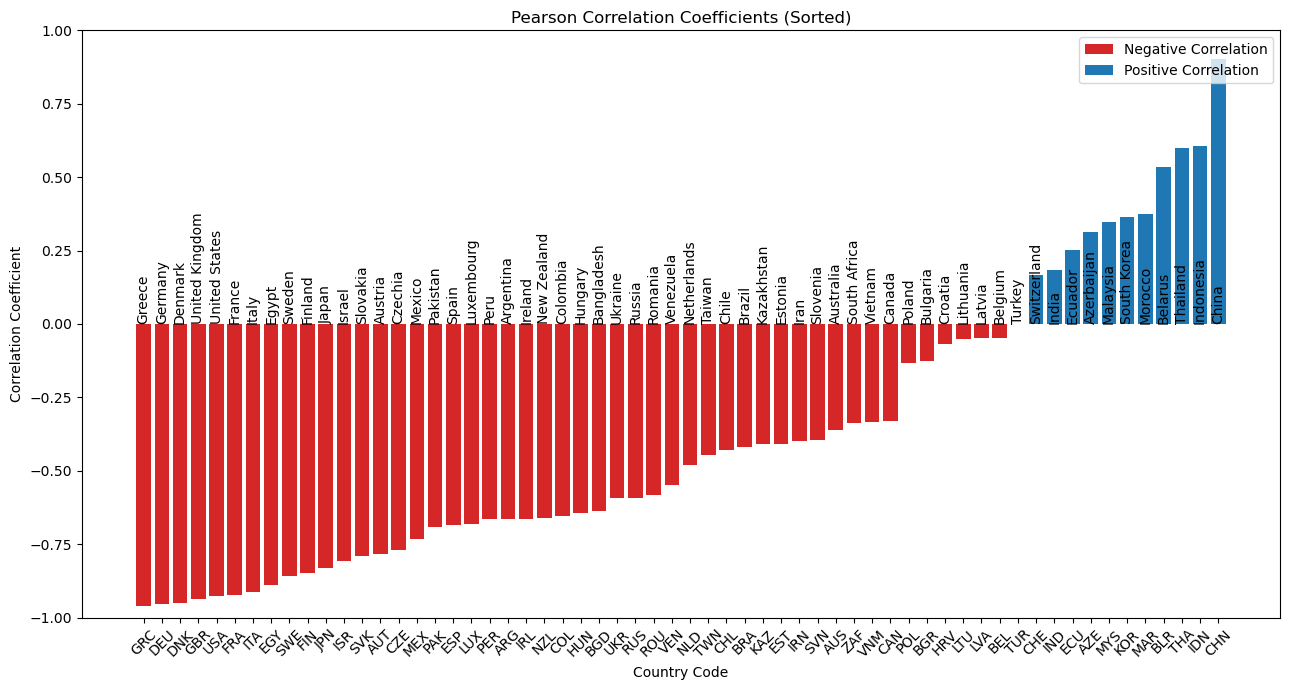

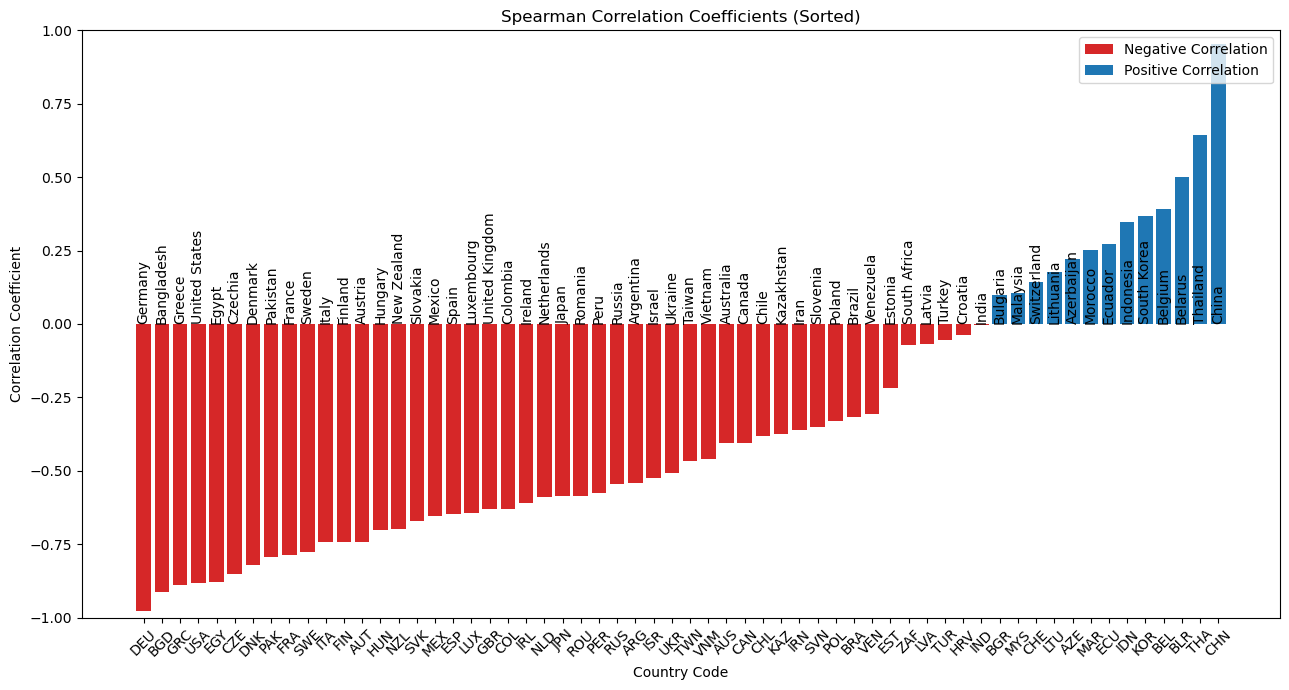

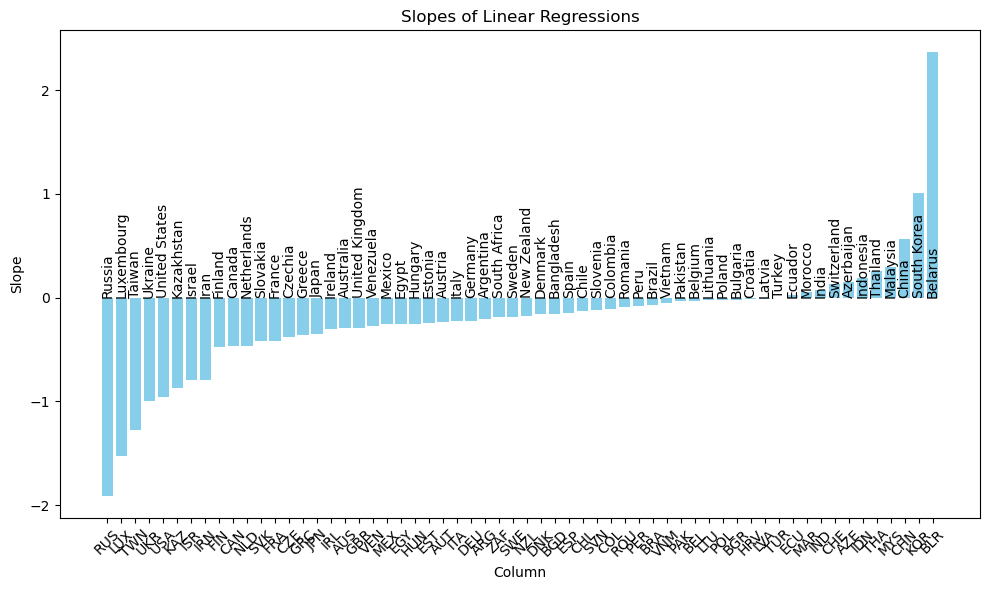

In [76]:
run_tests(renewables_filtered, co2_filtered)

# Run tests with detrending

In [33]:
def detrend_differencing(dataframe):
    detrended_dataframe = dataframe.copy()
    
    for column in dataframe.columns:
        detrended = detrended_dataframe[column].diff().fillna(0)
        detrended_dataframe[column] = detrended

    return detrended_dataframe

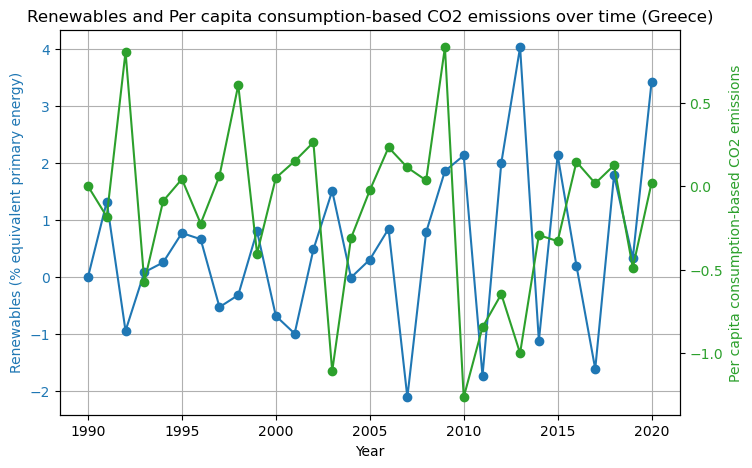

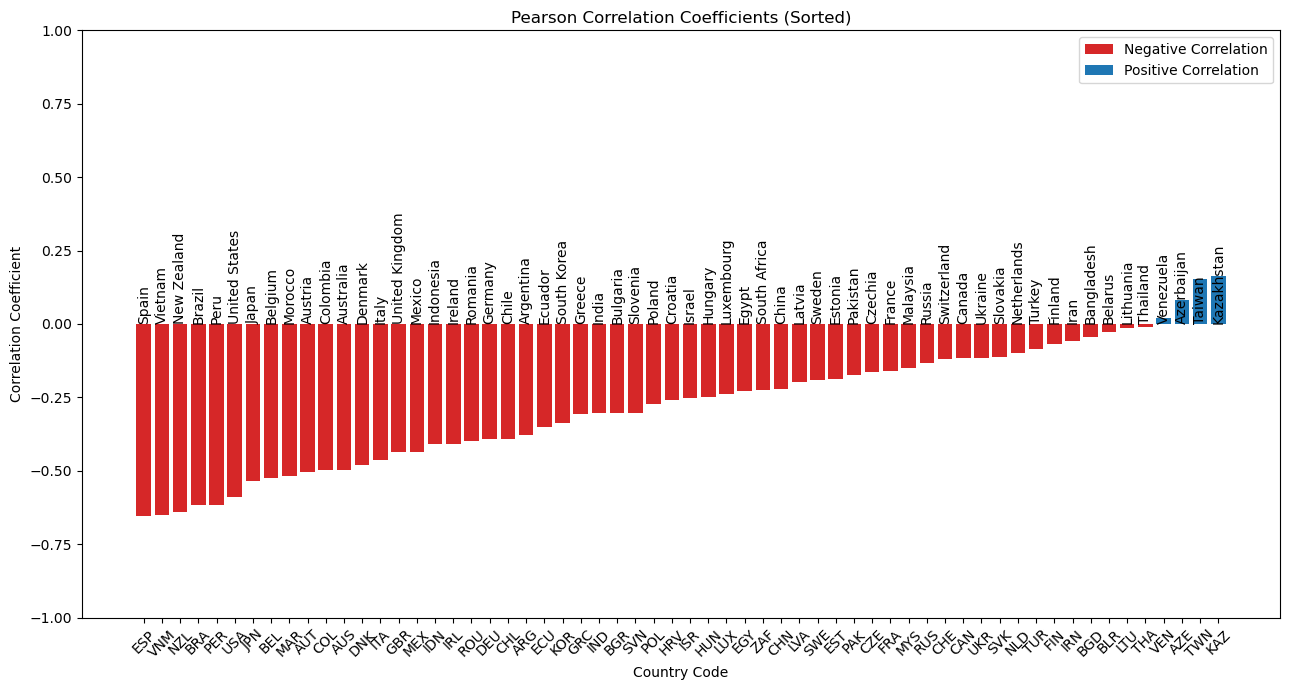

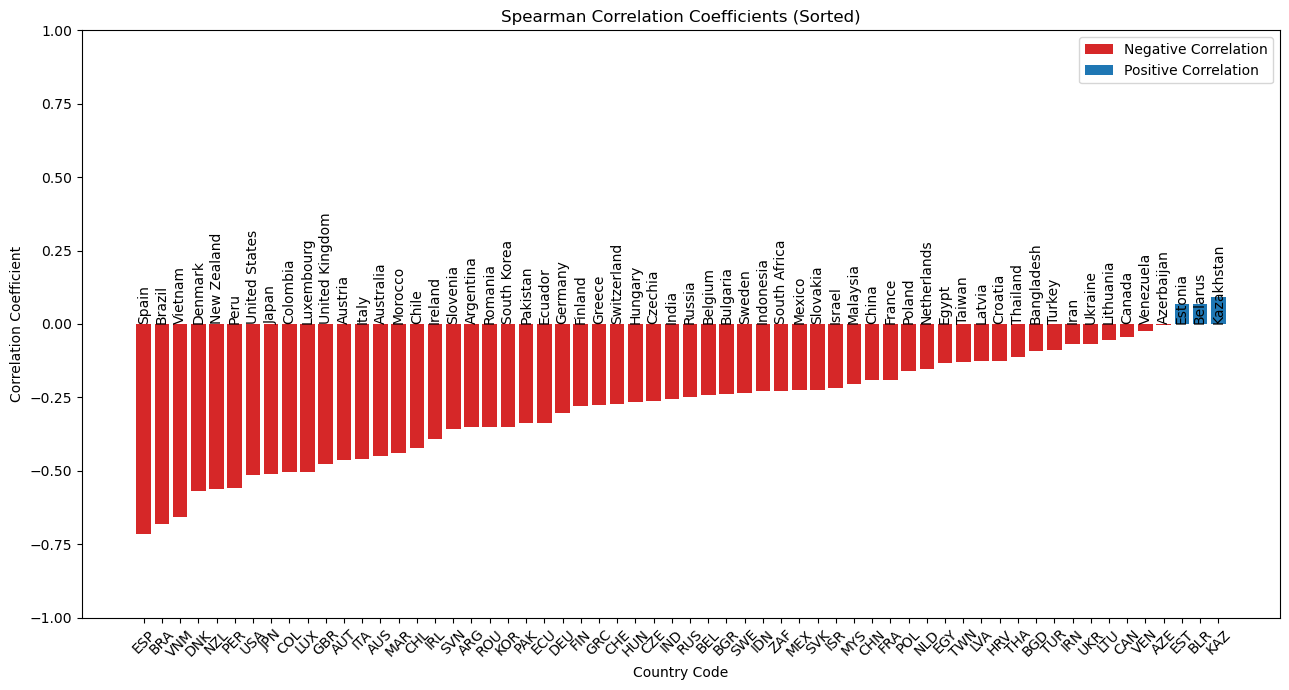

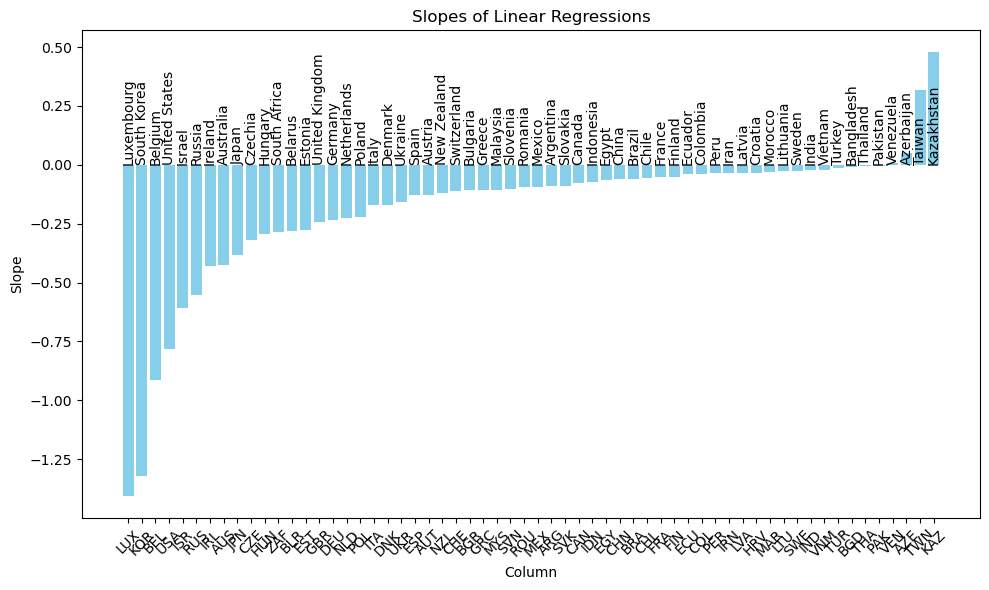

In [77]:
detrended_renewables_filtered = detrend_differencing(renewables_filtered)
detrended_co2_filtered = detrend_differencing(co2_filtered)

run_tests(detrended_renewables_filtered, detrended_co2_filtered)